In [1]:
%env ALL_PROXY=http://127.0.0.1:7897
%env HTTP_PROXY=http://127.0.0.1:7897
%env HTTPS_PROXY=http://127.0.0.1:7897

env: ALL_PROXY=http://127.0.0.1:7897
env: HTTP_PROXY=http://127.0.0.1:7897
env: HTTPS_PROXY=http://127.0.0.1:7897


In [2]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


2026-01-05 10:13:23.121871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
print(f"训练集形状: {X_train.shape}, 标签形状: {y_train.shape}")
print(f"测试集形状: {X_test.shape}, 标签形状: {y_test.shape}")

训练集形状: (60000, 28, 28), 标签形状: (60000,)
测试集形状: (10000, 28, 28), 标签形状: (10000,)


In [5]:
# 数据统计信息
print("\n数据集统计信息:")
print(f"训练集样本数: {len(X_train)}")
print(f"测试集样本数: {len(X_test)}")
print(f"图像尺寸: {X_train[0].shape[0]}x{X_train[0].shape[1]}像素")
print(f"标签类别: {np.unique(y_train)}")


数据集统计信息:
训练集样本数: 60000
测试集样本数: 10000
图像尺寸: 28x28像素
标签类别: [0 1 2 3 4 5 6 7 8 9]


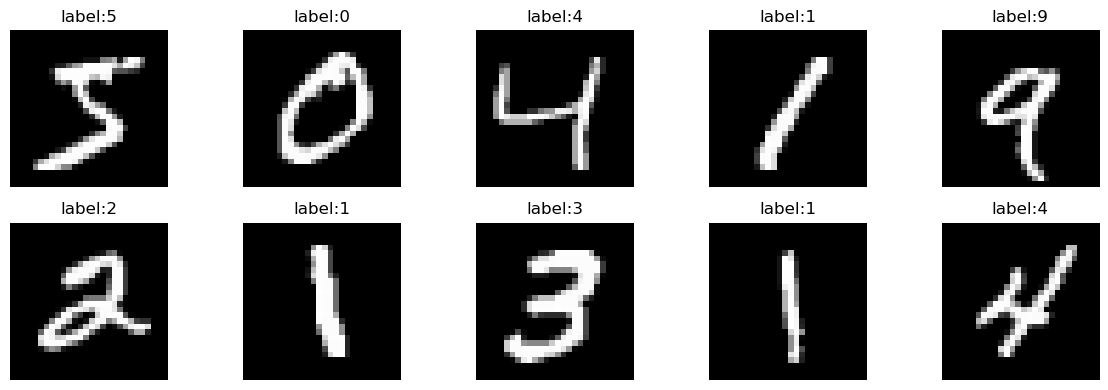

In [6]:
# 可视化前10个数字
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"label:{y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig(r"img/mnist_samples.png")

In [7]:
# 小样本数据集快速验证
def create_small_sample(X,y,sample_size=1000):
    # 随机采样（不放回）
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[indices]
    y_sample = y[indices]

    # 将图像数据展平(28，28) -> （784，）
    X_sample_flat = X_sample.reshape(-1, 28*28)

    # 归一化
    X_sample_flat = X_sample_flat.astype('float32') / 255.0

    return X_sample_flat, y_sample

In [8]:
# 创建小样本数据集 (1000个样本)
X_small, y_small = create_small_sample(X_train, y_train, sample_size=1000)

In [9]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

In [10]:
print(f"小样本训练集: {X_train_small.shape}")
print(f"小样本验证集: {X_test_small.shape}")

小样本训练集: (800, 784)
小样本验证集: (200, 784)


In [11]:
# 模型性能评估函数
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)       # 准确率不需要加权平均
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{model_name} 模型评估结果:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [12]:
# 数据标准化
scaler_svm = StandardScaler()
X_train_small_scaled = scaler_svm.fit_transform(X_train_small)
X_test_small_scaled = scaler_svm.transform(X_test_small)

In [13]:
# 创建并训练SVM
svm_small = SVC(kernel='linear', random_state=42, max_iter=1000)
svm_small.fit(X_train_small_scaled, y_train_small)

SVC(kernel='linear', max_iter=1000, random_state=42)

In [14]:
svm_metrics_small = evaluate_model(svm_small, X_test_small_scaled, y_test_small, "SVM")


SVM 模型评估结果:
Accuracy:  0.8750
Precision: 0.8779
Recall:    0.8750
F1 Score:  0.8740


In [16]:
import joblib
import os
from datetime import datetime

# 创建保存目录
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, scaler=None, model_name="model", dataset_name="mnist"):
    """
    保存模型和预处理器到本地
    
    Parameters:
    - model: 训练好的模型 (SVM或MLP)
    - scaler: 预处理器 (StandardScaler等)，可选
    - model_name: 模型名称 (如 "svm", "mlp")
    - dataset_name: 数据集名称
    """
    # 创建唯一的时间戳
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # 构建文件名
    model_filename = f"{model_name}_{dataset_name}_{timestamp}.joblib"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{timestamp}.joblib"
    
    # 完整路径
    model_path = os.path.join(MODEL_DIR, model_filename)
    scaler_path = os.path.join(MODEL_DIR, scaler_filename)
    
    # 保存模型
    joblib.dump(model, model_path)
    print(f"✅ 模型已保存到: {model_path}")
    
    # 保存预处理器（如果存在）
    if scaler is not None:
        joblib.dump(scaler, scaler_path)
        print(f"✅ 预处理器已保存到: {scaler_path}")
    
    return model_path, scaler_path if scaler else None

In [21]:
# 保存SVM模型（小样本）
svm_model_path, svm_scaler_path = save_model(
    model=svm_small,
    scaler=scaler_svm, 
    model_name="svm",
    dataset_name="mnist_small"
)

✅ 模型已保存到: models/svm_mnist_small_0105_0908.joblib
✅ 预处理器已保存到: models/svm_mnist_small_scaler_0105_0908.joblib


In [ ]:
# 创建并训练MLP
mlp_small = MLPClassifier(
    hidden_layer_sizes=(64,),  # 一个隐藏层，64个神经元
    activation='relu',
    solver='adam',
    max_iter=200,
    alpha=0.001,
    random_state=42,
    verbose=False,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_small.fit(X_train_small, y_train_small)

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(64,),
              random_state=42)

In [32]:
# 评估MLP
mlp_metrics_small = evaluate_model(mlp_small, X_test_small_scaled, y_test_small, "MLP")


MLP 模型评估结果:
Accuracy:  0.8500
Precision: 0.8565
Recall:    0.8500
F1 Score:  0.8475


In [20]:
# 保存MLP模型（小样本）
mlp_model_path, mlp_scaler_path = save_model(
    model=mlp_small,
    scaler=scaler_svm,  # MLP也使用相同的scaler
    model_name="mlp", 
    dataset_name="mnist_small"
)


✅ 模型已保存到: models/mlp_mnist_small_0105_0908.joblib
✅ 预处理器已保存到: models/mlp_mnist_small_scaler_0105_0908.joblib


In [33]:
n_iter = mlp_small.n_iter_
n_iter

31

In [34]:
loss_curve = mlp_small.loss_curve_
loss_curve

[2.5499844243274796,
 1.7276728259775376,
 1.231122073700693,
 0.9214611102806196,
 0.7082090381595824,
 0.5642751357740826,
 0.46199078340530403,
 0.3859699888202879,
 0.3288840991616249,
 0.28414544722769,
 0.2471255744682418,
 0.21662030545738012,
 0.1910830303311348,
 0.1689362893647618,
 0.1506169999043147,
 0.13482499468591477,
 0.12182508535385131,
 0.11025167361232968,
 0.10022798671589958,
 0.0916065568725268,
 0.08365525725285212,
 0.07699508327907986,
 0.0709329800274637,
 0.06588321002986697,
 0.06082607679367065,
 0.0564932864997122,
 0.052623600011401706,
 0.049152796461847094,
 0.04597328584194183,
 0.04329603831635581,
 0.040579319927427505]

In [35]:
# validation_scores = mlp_small.validation_scores_
print(mlp_small.validation_scores_)

[0.35, 0.525, 0.65, 0.6875, 0.7, 0.75, 0.775, 0.775, 0.8, 0.8, 0.8, 0.8, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.8125, 0.825, 0.8375, 0.8375, 0.8375, 0.8375, 0.8375, 0.8375, 0.8375, 0.825, 0.825, 0.825, 0.8375, 0.8375]
